<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting-Up" data-toc-modified-id="Setting-Up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting Up</a></span><ul class="toc-item"><li><span><a href="#Importing-modules" data-toc-modified-id="Importing-modules-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importing modules</a></span></li><li><span><a href="#Custom-written-functions" data-toc-modified-id="Custom-written-functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Custom written functions</a></span></li></ul></li><li><span><a href="#Setting-up" data-toc-modified-id="Setting-up-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setting up</a></span><ul class="toc-item"><li><span><a href="#Making-sure-subdirectories-are-set-up" data-toc-modified-id="Making-sure-subdirectories-are-set-up-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Making sure subdirectories are set up</a></span></li><li><span><a href="#Down/loading-data" data-toc-modified-id="Down/loading-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Down/loading data</a></span></li></ul></li><li><span><a href="#Cleaning-&amp;-parsing-data" data-toc-modified-id="Cleaning-&amp;-parsing-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cleaning &amp; parsing data</a></span></li><li><span><a href="#Lemmatization-with-SpaCy" data-toc-modified-id="Lemmatization-with-SpaCy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Lemmatization with SpaCy</a></span></li><li><span><a href="#Count-vectorization-with-TF-IDF" data-toc-modified-id="Count-vectorization-with-TF-IDF-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Count vectorization with TF-IDF</a></span></li><li><span><a href="#Dimensionality-Reduction---CorEx-model-with-10-topics" data-toc-modified-id="Dimensionality-Reduction---CorEx-model-with-10-topics-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Dimensionality Reduction - CorEx model with 10 topics</a></span></li><li><span><a href="#Sentiment-Analysis-using-VADER" data-toc-modified-id="Sentiment-Analysis-using-VADER-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Sentiment Analysis using VADER</a></span><ul class="toc-item"><li><span><a href="#Overlaying-Sentiment-and-Topic-Analysis" data-toc-modified-id="Overlaying-Sentiment-and-Topic-Analysis-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Overlaying Sentiment and Topic Analysis</a></span></li></ul></li><li><span><a href="#Visualizing-topic-words---Word-Clouds" data-toc-modified-id="Visualizing-topic-words---Word-Clouds-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Visualizing topic words - Word Clouds</a></span></li><li><span><a href="#Exploring-topics-v-companies" data-toc-modified-id="Exploring-topics-v-companies-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Exploring topics v companies</a></span></li><li><span><a href="#Clustering-Analysis---DBSCAN" data-toc-modified-id="Clustering-Analysis---DBSCAN-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Clustering Analysis - DBSCAN</a></span><ul class="toc-item"><li><span><a href="#DBSCAN-Clustering-Model" data-toc-modified-id="DBSCAN-Clustering-Model-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>DBSCAN Clustering Model</a></span></li></ul></li></ul></div>

# Setting Up

## Importing modules

In [1]:
import pickle
from IPython import display
from tqdm import tqdm
import time
import os
import copy
import zipfile as zf
# !pip install wget
import wget
from langdetect import detect
from requests.exceptions import Timeout, ConnectionError
from requests.packages.urllib3.exceptions import ReadTimeoutError
from ssl import SSLError
import re
import math
import numpy as np
import pandas as pd

import spacy
from spacy.attrs import *
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

from sklearn.decomposition import PCA, NMF

from corextopic import corextopic as ct
from corextopic import vis_topic as vt
import scipy.sparse as ss
from wordcloud import WordCloud

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /Users/Valentina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Valentina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%matplotlib inline
sns.set()
pd.set_option('display.max_colwidth', 1000)
tqdm.pandas()

## Custom written functions

In [4]:
def clean_companies(x):
    x = str(x.lower())
    if x in (['waiting','was','who','why','with','you','your','to','top','using','so','the','thing','probably',
              'quick','rupees','screen','service','mobile' ,'more','much' ,'my' ,'night' ,'no' ,'number','on',
              'or','out','phone', 'plans','me','manojsinhabjp', 'like' ,'limited','losses','gon','gonna','help',
              'home', 'complicated', 'd', 'declining', 'do','fed', 'flight', 'floor','food','for', 'fraudulent', 
              'from','glad','glitch', 'card', 'change' ,'be','being', 'bill', 'a' ,'access','account','activating',
              'i', 'boston', 'chicago', 'after']):
        return np.nan
    else:
        if x == 'airasia':
            return 'airasiasupport'
        elif x== 'centurylink':
            return 'centurylinkhelp'
        elif x == 'chase':
            return 'chasesupport'
        elif x == 'verizon':
            return 'verizonsupport'
        elif x == 'uber':
            return 'uber_support'
        else:
            return x

In [5]:
def clean_tweets(x):
    '''
    Removes links, @s, hashtags, line breaks and slashes from tweets. Returns NaNs if 
    '''
    try:
        if (re.search('[A-Za-z]+', x)) and (detect(x) == 'en'):
            return re.sub('@[\w\d\S]+|https?:\/\/[^\s]*|(\\n)+|#[\w\d]+|&amp;|[\/]+', ' ', x)
        else:
            return np.nan
    except:
        return np.nan

In [6]:
def count_unique_tweets(x):
    '''
    Counts number of unique tweets in a list
    '''
    return len(set(x))

In [7]:
def get_at(x):
    if re.search('(@[A-Za-z]+_*[A-Za-z]+)(\s.+)', x):
        return re.search('(@[A-Za-z]+_*[A-Za-z]+)(\s.+)', x).group(1)
    else:
        return np.nan

In [8]:
def get_company(x, ref_df):
    ID = int(x)
    return ref_df[ref_df['tweet_id'] == ID]['@'].max()

In [9]:
def get_sentiment(x):
    sent = VADER_analyzer.polarity_scores(x)['compound']
    if sent < 0:
        return -1
    elif sent >=0:
        return 1

In [10]:
def lemmatize(x):
    doc = nlp(x)
    return " ".join([token.lemma_ if token.lemma_ != '-PRON-' else '' for token in doc])

In [11]:
def remove_ats(x):
    return re.sub('@', '', x)

In [12]:
def tweet_class(x):
    '''
    Determine whether tweet is from user or company
    '''
    if re.match('[\d]+', x):
        return 'user'
    else:
        return 'company'

In [13]:
def update_tweet_count(x, other_df):
    '''
    Updates tweet count by checking concurrent dataframe
    INPUT: dataframe to check
    '''
    try:
        count = int(other_df[other_df['user']==x]['size'].mean())
    except:
        count = 0
    return count

# Setting up

## Making sure subdirectories are set up

In [4]:
pickle_path = './pickles'
if os.path.exists(pickle_path):
    print('Pickle path already exists - no need to do anything!')
else:
    try:
        os.mkdir(pickle_path)
    except OSError:
        print ("Creation of the directory %s failed" % pickle_path)
    else:
        print ("Successfully created the directory %s " % pickle_path)

Pickle path already exists - no need to do anything!


## Down/loading data

In [14]:
# Check if data already exists in current directory - if not downloads it as zip and extracts it
if os.path.exists('./twcs/twcs.csv'):
    pass
else:
    download_path = os.path.expanduser('~/Downloads')
    print('Downloading the Customer Service tweets data file...')

    url = 'https://storage.googleapis.com/kaggle-data-sets/4133/8841/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1569363982&Signature=l55H2DK%2F4WP0pa%2F4TkteF8hTJdl3RDZjaD%2BkEJpThl99%2BmvTzj4vTj637DoCk3tPmMYAuCJlowd2RpVnYZiVxGop39g5gwey%2BC9b%2FhIZ1KpczfnCjmQOWvi3LninuPChO%2FBuE%2BF2bv9qEev6TO%2BUZlRNPNbfrRZ48yVhqhP41Ur64QXw2vU%2FyVNr6EmlJLQaV0XsdnzwpEcqHU5gd2bPk3Txn8lNRUk4X%2FhIcOOHtsYjLQvfdEftUZhdrru7R9if10JUAKiKlUOC3QR%2FGLWA%2FxQTkU%2Bi4BqiVYtQEsYQJUKrHnPHCXLeiwdAiVZz9EBxtaFmZzUpqe%2FxlabxC608vw%3D%3D&response-content-disposition=attachment%3B+filename%3Dcustomer-support-on-twitter.zip'
    wget.download(url, download_path)
    
    filepath = f'{download_path}/customer-support-on-twitter.zip'
    with zf.ZipFile(filepath, 'r') as zip:
        zip.printdir()
        zip.extract('twcs/twcs.csv')

In [15]:
# Create dataframe from customer service tweets
all_tweets = pd.read_csv('./twcs/twcs.csv')

In [16]:
all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
tweet_id                   int64
author_id                  object
inbound                    bool
created_at                 object
text                       object
response_tweet_id          object
in_response_to_tweet_id    float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB


**Let's see what our original tweets look like...**

In [17]:
all_tweets['text'].sample(20)

892966                                                                                                                                                                                                                                                                 @hulu_support Yep, I'm in the US.
2427497                                                                                                                                                                   @AppleSupport advice for having duplicates in my movie library? This all started when I started using the Movies Anywhere app.
1829603                                                                                                                                                                                                                       @Ask_Spectrum it’s been like this for at least two days. #payingForNothing
745307                                                                                                       

**As you can see, there's all kinds of of messiness. From "@"s and "#"s, to links and even emojis! 😱**

**We'll have to clean that up...**

# Cleaning & parsing data

In [18]:
# Marking whether tweet is from user or company
all_tweets['from'] = all_tweets['author_id'].progress_apply(tweet_class)

# Pickle original tweets (all)
with open('./pickles/tweets_original.pkl', 'wb') as tweets_original:
    pickle.dump(all_tweets, tweets_original)

df_customers = all_tweets[all_tweets['from'] == 'user']
df_customers.reset_index(drop=True, inplace=True)

# Selecting a subset of 500K tweets
df_customers_subset = df_customers.iloc[:500000, :]

# Pickle original customer tweets
with open('./pickles/customer_tweets_original.pkl', 'wb') as cust_original:
    pickle.dump(df_customers_subset, cust_original)

# Remove RTs, @s, #s, and others form tweets
df_customers_subset['text'] = df_customers_subset['text'].astype('str') 
df_customers_subset['@'] = df_customers_subset['text'].progress_apply(get_at)
df_customers_subset['text'] = df_customers_subset['text'].progress_apply(clean_tweets)
df_customers_subset['text'] = df_customers_subset['text'].astype('str') 
df_customers_subset['tweet_len'] = df_customers_subset['text'].progress_apply(len)

# Pickle cleaned customer tweets subset
with open('./pickles/customer_tweets_subset.pkl', 'wb') as cust_subset:
    pickle.dump(df_customers_subset, cust_subset)

# Get tweets that are at least 40 characters long
df_minlen = df_customers_subset[df_customers_subset['tweet_len'] > 40]

# Pickle data frame with minimum length tweets
with open('./pickles/customer_subset_long.pkl', 'wb') as c_subset_l:
    pickle.dump(df_minlen, c_subset_l)

# Removing duplicate tweets
cust_tweets = df_minlen.drop_duplicates(subset=['author_id', 'text'], keep='first')
cust_tweets.reset_index(drop=True, inplace=True)

with open('./pickles/customer_tweets_clean.pkl', 'wb') as cust_tweets_final:
    pickle.dump(cust_tweets, cust_tweets_final)

100%|██████████| 2811774/2811774 [00:07<00:00, 355140.49it/s]
/Users/Valentina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 500000/500000 [00:02<00:00, 246848.73it/s]
/Users/Valentina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 500000/500000 [51:43<00:00, 161.08it/s]  
/Users/Valentina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value i

In [19]:
cust_tweets.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,from,@,tweet_len
0,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,I have sent several private messages and no one is responding as usual,1,4.0,user,@sprintcare,72
1,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,You gonna magically change your connectivity for me and my whole family ? 🤥 💯,"11,13,14",15.0,user,@sprintcare,79
2,16,115713,True,Tue Oct 31 20:00:43 +0000 2017,Since I signed up with you....Since day 1,15,17.0,user,@sprintcare,43
3,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,"y’all lie about your “great” connection. 5 bars LTE, still won’t load something. Smh.",17,NaN,user,NaN,87
4,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"whenever I contact customer support, they tell me I have shortcode enabled on my account, but I have never in the 4 years I've tried",19,NaN,user,NaN,136


# Lemmatization with SpaCy

In [20]:
# Load pickle of final working dataframe
with open('./pickles/customer_tweets_clean.pkl', 'rb') as cust_tweets:
    cust_tweets = pickle.load(cust_tweets)

**Let's have a peek at our cleaned tweets...**

In [21]:
cust_tweets['text'].sample(20)

282356                                                                                                                                                             complained on sept 3rd told would be dealt with by 19th Sept. Resent complaint 3rd Oct. Heard nothing by 11th Oct.  
298226                                                                                                                                                                                                     I was defrauded in my order number  -5541471-9760348  ACTION EXPECTED FROM  
255791                                                                                                               How u guys are making fool if u really did investigation give me proof. Without my Id, call , singature how   delevered product to me .If u r right give me proof.
337267                                                                                                                                                          

In [22]:
# I built my own custom list of words to lemmatize built on general twitter-observations...
nlp = spacy.load('en', disable=['parser'])

nlp.tokenizer.add_special_case("tweet", [{ORTH: u'tweet', LEMMA: u'twitter', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("twitt", [{ORTH: u'twitt', LEMMA: u'twitter', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("truly", [{ORTH: u'truly', LEMMA: u'true', POS: u'ADV'}])
nlp.tokenizer.add_special_case("usually", [{ORTH: u'usually', LEMMA: u'usual', POS: u'ADV'}])
nlp.tokenizer.add_special_case("vibes", [{ORTH: u'vibes', LEMMA: u'vibe', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("teacher", [{ORTH: u'teacher', LEMMA: u'teach', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("therpist", [{ORTH: u'therapist', LEMMA: u'therapy', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("threaten", [{ORTH: u'threaten', LEMMA: u'threat', POS: u'VB'}])
nlp.tokenizer.add_special_case("til", [{ORTH: u'til', LEMMA: u'till', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("spiritual", [{ORTH: u'spiritual', LEMMA: u'spirit', POS: u'ADV'}])
nlp.tokenizer.add_special_case("standing", [{ORTH: u'standing', LEMMA: u'stand', POS: u'VB'}])
nlp.tokenizer.add_special_case("states", [{ORTH: u'states', LEMMA: u'state', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("strong", [{ORTH: u'strong', LEMMA: u'strength', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("student", [{ORTH: u'student', LEMMA: u'study', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("successful", [{ORTH: u'successful', LEMMA: u'success', POS: u'ADV'}])
nlp.tokenizer.add_special_case("suddenly", [{ORTH: u'suddenly', LEMMA: u'sudden', POS: u'ADV'}])
nlp.tokenizer.add_special_case("sunny", [{ORTH: u'sunny', LEMMA: u'sun', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("supporter", [{ORTH: u'supporter', LEMMA: u'support', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("surprised", [{ORTH: u'surprised', LEMMA: u'surprise', POS: u'VB'}])
nlp.tokenizer.add_special_case("surprising", [{ORTH: u'surprising', LEMMA: u'surprise', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("shitty", [{ORTH: u'shitty', LEMMA: u'shit', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("shooting", [{ORTH: u'shooting', LEMMA: u'shoot', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("shooting", [{ORTH: u'shooting', LEMMA: u'shoot', POS: u'VB'}])
nlp.tokenizer.add_special_case("shopping", [{ORTH: u'shopping', LEMMA: u'shop', POS: u'VB'}])
nlp.tokenizer.add_special_case("silent", [{ORTH: u'silent', LEMMA: u'silence', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("simply", [{ORTH: u'simply', LEMMA: u'simple', POS: u'ADV'}])
nlp.tokenizer.add_special_case("singing", [{ORTH: u'singing', LEMMA: u'sing', POS: u'VB'}])
nlp.tokenizer.add_special_case("sis", [{ORTH: u'sis', LEMMA: u'sister', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("slowly", [{ORTH: u'slowly', LEMMA: u'slow', POS: u'ADV'}])
nlp.tokenizer.add_special_case("soften", [{ORTH: u'soften', LEMMA: u'soft', POS: u'VB'}])
nlp.tokenizer.add_special_case("smoking", [{ORTH: u'smoking', LEMMA: u'smoke', POS: u'VB'}])
nlp.tokenizer.add_special_case("speaker", [{ORTH: u'speaker', LEMMA: u'speak', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("speech", [{ORTH: u'speech', LEMMA: u'speak', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("specifically", [{ORTH: u'specifically', LEMMA: u'specific', POS: u'ADV'}])
nlp.tokenizer.add_special_case("serve", [{ORTH: u'serve', LEMMA: u'service', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("texte", [{ORTH: u'texte', LEMMA: u'text', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("bro", [{ORTH: u'bro', LEMMA: u'brother', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("bday", [{ORTH: u'bday', LEMMA: u'birthday', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("ppl", [{ORTH: u'ppl', LEMMA: u'people', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("absolutely", [{ORTH: u'absolutely', LEMMA: u'absolute', POS: u'ADV'}])
nlp.tokenizer.add_special_case("acceptable", [{ORTH: u'acceptable', LEMMA: u'accept', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("accounts", [{ORTH: u'accounts', LEMMA: u'account', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("actually", [{ORTH: u'actually', LEMMA: u'actual', POS: u'ADV'}])
nlp.tokenizer.add_special_case("added", [{ORTH: u'added', LEMMA: u'add', POS: u'VB'}])
nlp.tokenizer.add_special_case("adding", [{ORTH: u'adding', LEMMA: u'add', POS: u'VB'}])
nlp.tokenizer.add_special_case("additional", [{ORTH: u'additional', LEMMA: u'add', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("advise", [{ORTH: u'advise', LEMMA: u'advice', POS: u'VB'}])
nlp.tokenizer.add_special_case("advise", [{ORTH: u'advise', LEMMA: u'advice', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("agents", [{ORTH: u'agents', LEMMA: u'agent', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("airlines", [{ORTH: u'airlines', LEMMA: u'airline', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("allowed", [{ORTH: u'allowed', LEMMA: u'allow', POS: u'VB'}])
nlp.tokenizer.add_special_case("american", [{ORTH: u'american', LEMMA: u'america', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("answers", [{ORTH: u'answers', LEMMA: u'answer', POS: u'VB'}])

In [23]:
# Apply lemmatization
cust_tweets['lemma_tweets'] = cust_tweets['text'].progress_apply(lemmatize)
with open('./pickles/lemmatized_tweets.pkl', 'wb') as lemma_tweets:
    pickle.dump(cust_tweets, lemma_tweets)

100%|██████████| 387428/387428 [43:43<00:00, 147.68it/s] 


Let's see how the lemmatized tweets came out...

In [24]:
cust_tweets['lemma_tweets'].sample(10)

151640                                                                                be no longer possible to view anything other than previously buy item ,  can not search anything on the app
320858    second time in the past couple of month that  have not receive a delivery from    despite  be " with the carrier " and all the parcel track information say be " there be a problem "  
281933                                                                                           be  miss  or be the only way to change  password to sign out and click on " forget  password " ?
109747                                                                                                                              be an ebay user since the ' 90 and  be always work in Firefox
2371                                                                                      that be at bag claim ; same thing happen to  other bag last week .. tell those bag handler to chill 😂 😂
141645                        

# Count vectorization with TF-IDF

In [26]:
with open('./pickles/lemmatized_tweets.pkl', 'rb') as lemma_tweets:
    cust_tweets = pickle.load(lemma_tweets)

EOFError: Ran out of input

In [27]:
# I built my own list of stopwords to be excluded when tokenizing
custom_stopwords = text.ENGLISH_STOP_WORDS.union(stopwords.words('english'),['wow','yorker', 'yorkers','tue','lmao', 
                                                                             'lmaoo', 'lmaooo', 'lmaoooo','abc', 
                                                                             'yah','tues', 'cont','sept', 'llc', 
                                                                             'somebody', 'everybody','brocantebedstuy',
                                                                             'yas','yass', 'yasss','yay','yea', 'yeah',
                                                                             'yes', 'yep','no','nope','nah','na',
                                                                             'ytd','yall','abf', 'fps','doesn',
                                                                             'gotta','aug', 'august','monday','isn',
                                                                             'ain','having','haven','didn','coll',
                                                                             'pdt','abt','yrs', 'yuh','yup', 'good',
                                                                             'city','nyc', 'ny','york','new york', 
                                                                             'new york city', 'come', 'did', 'don', 
                                                                             'got', 'really', 'way','just', 
                                                                             'new york times','lemme', 'let', 
                                                                             'thing', 'things', 'gonna', 'getting', 
                                                                             'get','ggs','af', 'ft', 'th', 'yo', 'uh',
                                                                             'tl', 'st', 'smh', 'tf', 'min', 'tho', 
                                                                             'll', 'kjv', 'wtf']
                                                                             + list(string.punctuation))

In [28]:
vectorizer = TfidfVectorizer(min_df=300, max_df=0.3, ngram_range=(1,2), stop_words=custom_stopwords, 
                             token_pattern='[A-Za-z]{3,}')
X = vectorizer.fit_transform(tqdm(cust_tweets['lemma_tweets']))
tfidf_matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

  0%|          | 0/387428 [00:00<?, ?it/s]/Users/Valentina/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['new', 'times'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
100%|██████████| 387428/387428 [00:11<00:00, 33343.89it/s]


# Dimensionality Reduction - CorEx model with 10 topics

/Users/Valentina/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['new', 'times'] not in stop_words.
  'stop_words.' % sorted(inconsistent))





Here are the topics found and their top related words:


0: order, delivery, deliver, package, arrive, prime, amazon, day, item, today
1: phone, app, fix, iphone, ios, update, battery, apple, crash, new
2: service, customer, support, care, experience, tech, bad, poor, terrible, loyal
3: flight, book, fly, seat, bag, plane, airport, gate, airline, crew
4: account, error, access, log, password, login, try, code, email, hack
5: fix, internet, download, reset, speed, problem, issue, outage, connection, cable
6: cancel, trip, drive, car, driver, charge, uber, ride, cancellation, park
7: card, refund, purchase, payment, credit, debit, gift, money, method, sim
8: buy, offer, purchase, deal, coupon, ticket, store, price, friday, black
9: game, play, music, stream, song, xbox, watch, video, listen, live





Text(0.5, 1.0, 'Correlation magnitude between words for each topic extracted (the larger the better)')

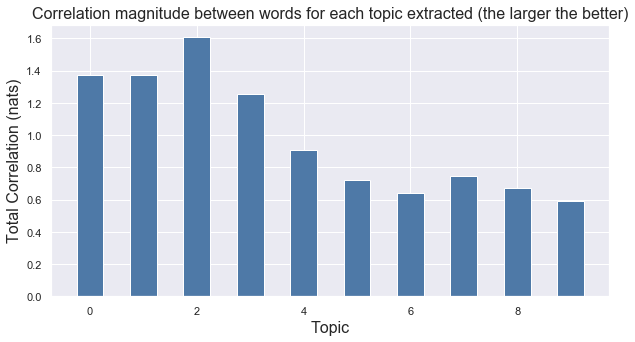

In [29]:
corex_vectorizer = CountVectorizer(max_features=20000,
                             stop_words=custom_stopwords, token_pattern='[A-Za-z]{3,}', min_df=300,
                             binary=True)

doc_word = corex_vectorizer.fit_transform(cust_tweets['lemma_tweets'])
words = list(np.asarray(corex_vectorizer.get_feature_names()))

corex_topic_model = ct.Corex(n_hidden=10, words=words, seed=1, max_iter = 400, verbose = False)
corex_topic_model.fit(doc_word, words = words, docs = cust_tweets['lemma_tweets'], 
                anchors=[['order', 'deliver', 'delivery', 'package', 'arrive'], 
                         ['ios', 'app', 'iphone', 'fix', 'phone'], 
                         ['customer', 'service', 'care', 'experience', 'tech', 'support'], 
                         ['flight', 'seat', 'fly', 'book', 'plane', 'gate', 'crew', 'bag', 'airport', 'airline'],
                         ['account', 'error', 'log', 'login', 'password', 'access'],
                         ['internet', 'reset', 'fix', 'download'], 
                         ['drive', 'cancel', 'car', 'trip'],
                         ['purchase','payment', 'card', 'refund'],
                         ['buy', 'purchase', 'deal', 'offer', 'coupon'],
                         ['music', 'tv', 'game', 'stream', 'play']], anchor_strength = 5)

# Build a DataFrame with matching each tweet to a designated topic based on the CorEx model
CorEx_predictions = pd.DataFrame(corex_topic_model.p_y_given_x, columns=['topic'+str(i) for i in range(10)])
CorEx_predictions.columns=(['shopping_delivery', 'phone_gadget', 'customer_service', 'flight_travel', 
                            'account_details', 'internet', 'car_transport', 'payment_refunds', 'deals', 
                            'entertainment'])
print('\n\n')

# Print all topics from the CorEx topic model
corex_topics = corex_topic_model.get_topics()
print('Here are the topics found and their top related words:')
print('\n')
for n,topic in enumerate(corex_topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))
print('\n\n')  

# Plotting the correlations for the words within each topic (measure of topic cohesion)
plt.figure(figsize=(10,5))
plt.bar(range(corex_topic_model.tcs.shape[0]), corex_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.title('Correlation magnitude between words for each topic extracted (the larger the better)', fontsize=16)
# plt.savefig('corex_loadings.png', format='png', bbox_inches='tight'); #uncomment if you want to save figure locally

**If you want to read through a selection of tweets for each topic, you can play around with the command below. The "topic" argument determines which topic you're querying (possible arguments are: 0-9), the "n_docs" argument determines the number of exemplars to be returned**

In [ ]:
corex_topic_model.get_top_docs(topic=8, n_docs=10)

# Sentiment Analysis using VADER

In [30]:
VADER_analyzer = SentimentIntensityAnalyzer()

cust_tweets['sentiment'] = cust_tweets['text'].progress_apply(get_sentiment)

with open('./pickles/sentiment_tweets.pkl', 'wb') as sent_tweets:
    pickle.dump(cust_tweets, sent_tweets)

100%|██████████| 387428/387428 [02:34<00:00, 2511.46it/s]


## Overlaying Sentiment and Topic Analysis

In [ ]:
with open('./pickles/sentiment_tweets.pkl', 'rb') as sent_tweets:
    cust_tweets = pickle.load(sent_tweets)

In [31]:
cust_tweets.reset_index(drop=True, inplace=True)

analysis_df = pd.concat([cust_tweets, CorEx_predictions], axis=1)
analysis_df.dropna(subset=['@'], axis=0, inplace=True)
analysis_df['@'] = analysis_df['@'].astype('str') 
analysis_df['company'] = analysis_df['@'].progress_apply(remove_ats)
analysis_df['top_topic'] = (analysis_df[['shopping_delivery', 'phone_gadget', 'customer_service', 'flight_travel', 
                                         'account_details', 'internet', 'car_transport', 'payment_refunds', 'deals',
                                         'entertainment']].idxmax(axis=1))

# Cleaning up fields no longer needed
del analysis_df['inbound'] 
del analysis_df['created_at'] 
del analysis_df['response_tweet_id'] 
del analysis_df['in_response_to_tweet_id']

# Moderating topics by sentiment
analysis_df['shopping_delivery_sent'] = analysis_df['sentiment'] * analysis_df['shopping_delivery']
analysis_df['phone_gadget_sent'] = analysis_df['sentiment'] * analysis_df['phone_gadget']
analysis_df['customer_service_sent'] = analysis_df['sentiment'] * analysis_df['customer_service']
analysis_df['flight_travel_sent'] = analysis_df['sentiment'] * analysis_df['flight_travel']
analysis_df['account_details_sent'] = analysis_df['sentiment'] * analysis_df['account_details']
analysis_df['internet_sent'] = analysis_df['sentiment'] * analysis_df['internet']
analysis_df['car_transport_sent'] = analysis_df['sentiment'] * analysis_df['car_transport']
analysis_df['payment_refunds_sent'] = analysis_df['sentiment'] * analysis_df['payment_refunds']
analysis_df['deals_sent'] = analysis_df['sentiment'] * analysis_df['deals']
analysis_df['entertainment_sent'] = analysis_df['sentiment'] * analysis_df['entertainment']

with open('./pickles/sentiment_topic_modeling.pkl', 'wb') as topics_and_sent:
    pickle.dump(analysis_df, topics_and_sent)

100%|██████████| 281535/281535 [00:00<00:00, 360940.89it/s]


# Visualizing topic words - Word Clouds

In [32]:
phone_df = analysis_df[analysis_df['top_topic'] == 'phone_gadget']
shopping_df = analysis_df[analysis_df['top_topic'] == 'shopping_delivery']
travel_df = analysis_df[analysis_df['top_topic'] == 'flight_travel']
cs_df = analysis_df[analysis_df['top_topic'] == 'customer_service']
internet_df = analysis_df[analysis_df['top_topic'] == 'internet']
payment_df = analysis_df[analysis_df['top_topic'] == 'payment_refunds']
account_df = analysis_df[analysis_df['top_topic'] == 'account_details']
car_df = analysis_df[analysis_df['top_topic'] == 'car_transport']
deals_df = analysis_df[analysis_df['top_topic'] == 'deals']
entertainment_df = analysis_df[analysis_df['top_topic'] == 'entertainment']

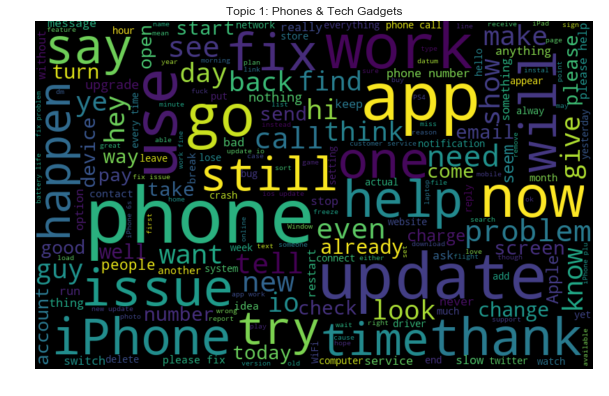

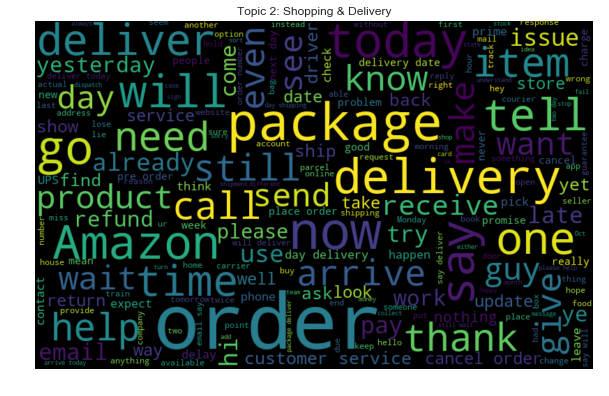

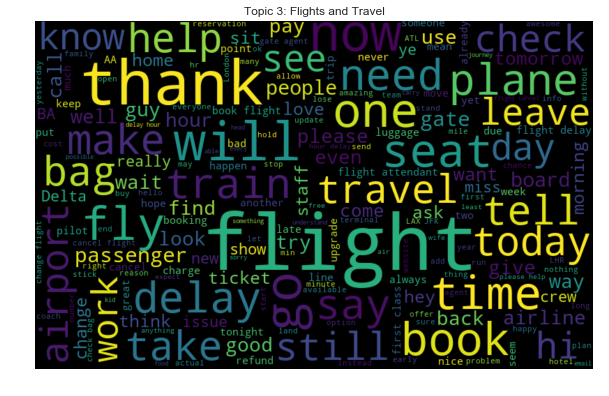

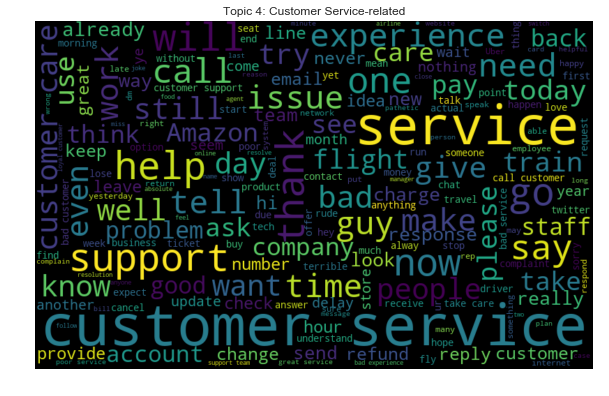

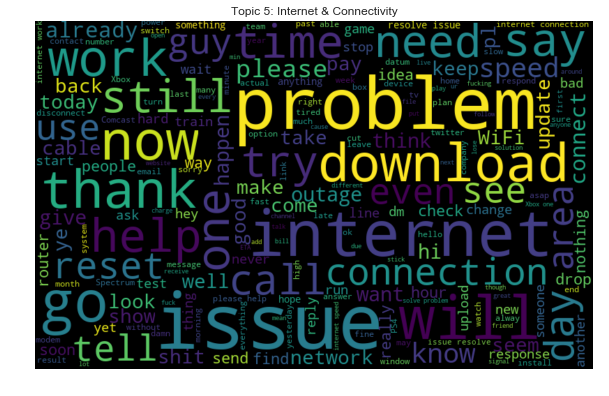

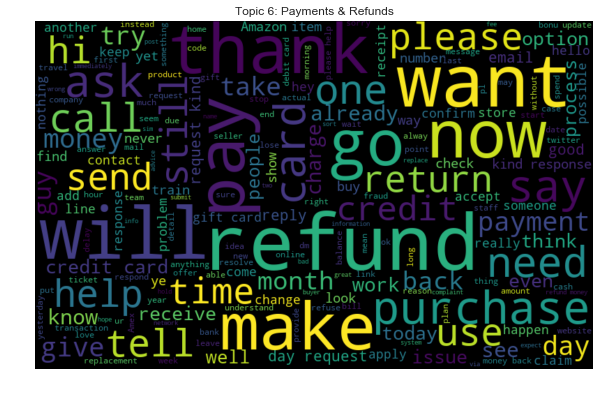

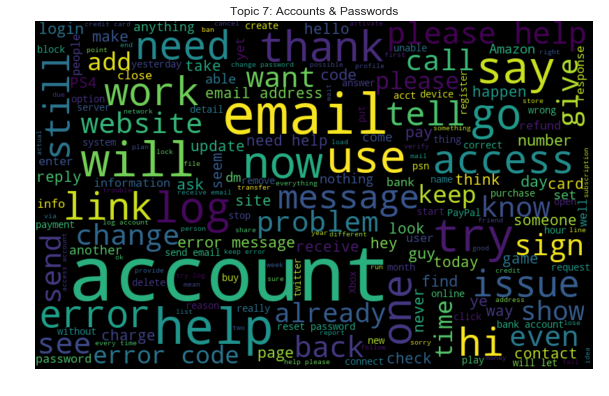

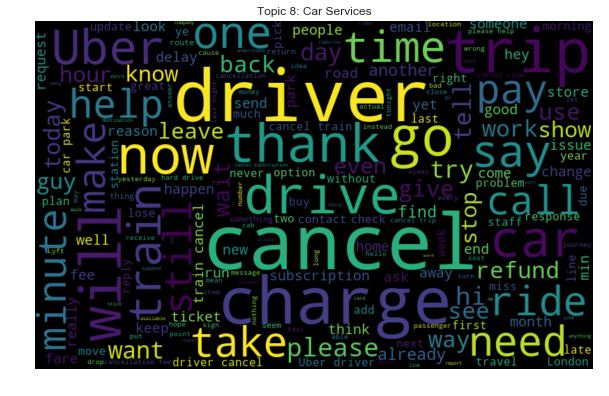

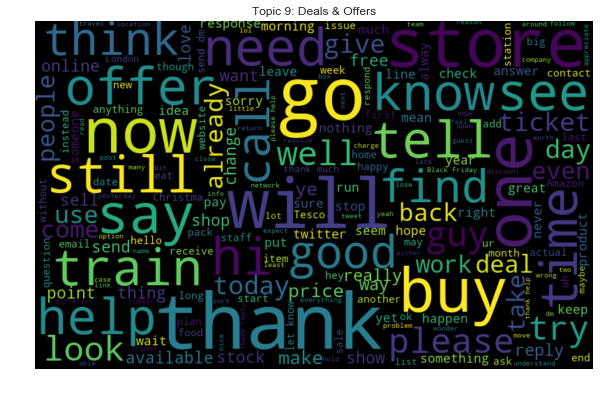

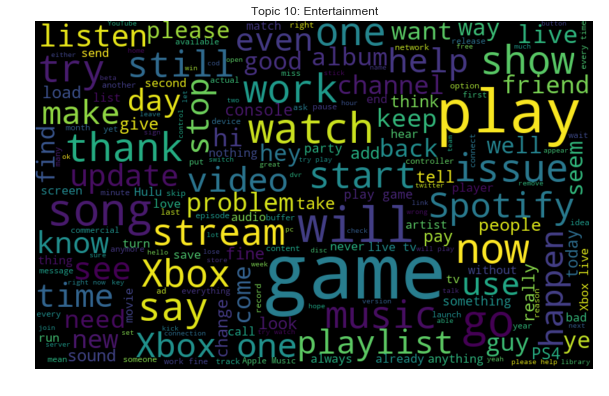

In [33]:
all_words = ' '.join([text for text in phone_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Topic 1: Phones & Tech Gadgets')
plt.show()

all_words = ' '.join([text for text in shopping_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Topic 2: Shopping & Delivery')
plt.show()

all_words = ' '.join([text for text in travel_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Topic 3: Flights and Travel')
plt.show()

all_words = ' '.join([text for text in cs_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Topic 4: Customer Service-related')
plt.show()

all_words = ' '.join([text for text in internet_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Topic 5: Internet & Connectivity')
plt.show()

all_words = ' '.join([text for text in payment_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Topic 6: Payments & Refunds')
plt.show()

all_words = ' '.join([text for text in account_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Topic 7: Accounts & Passwords')
plt.show()

all_words = ' '.join([text for text in car_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Topic 8: Car Services')
plt.show()

all_words = ' '.join([text for text in deals_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Topic 9: Deals & Offers')
plt.show()

all_words = ' '.join([text for text in entertainment_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Topic 10: Entertainment')
plt.show()

# Exploring topics v companies

In [ ]:
with open('./pickles/sentiment_topic_modeling.pkl', 'rb') as topics_and_sent:
    analysis_df = pickle.load(topics_and_sent)

Out of curiosity, let's peek at some of the companies extracted...

In [34]:
analysis_df.company.sample(10)

14226     British_Airways
338823       VirginTrains
64001      MicrosoftHelps
148314       SouthwestAir
73385           AskPayPal
208770     AskPlayStation
280687         AmazonHelp
290978       AppleSupport
221066     AskPlayStation
78143                 ATT
Name: company, dtype: object

Text(0.5, 1.0, 'Number of tweets for each of the top tweeted-about topics')

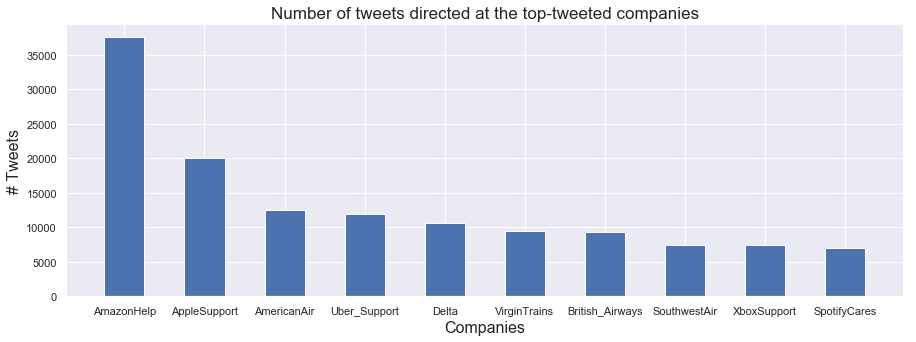

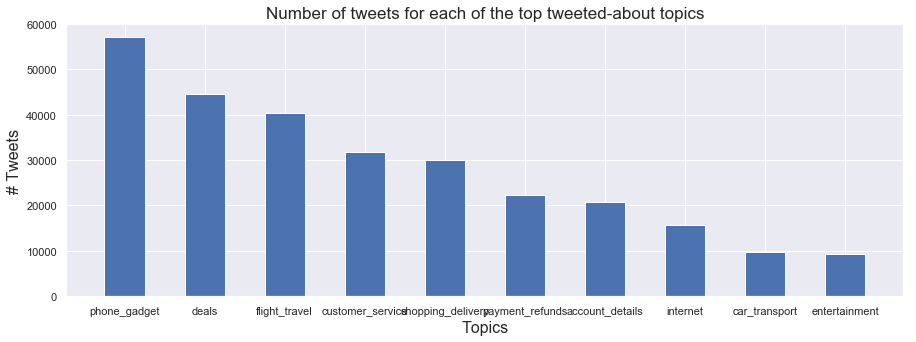

In [35]:
# Extracting top tweeted companies and top tweeted-about topics
top_companies = analysis_df['company'].value_counts().index[0:10]
top_topics = analysis_df['top_topic'].value_counts().index[0:10]
company_counts = analysis_df['company'].value_counts()[0:10]
topic_counts = analysis_df['top_topic'].value_counts()[0:10]

# Plotting the above
plt.figure(figsize=(15,5))
plt.bar(top_companies, company_counts, width=0.5)
plt.xlabel('Companies', fontsize=16)
plt.ylabel('# Tweets', fontsize=16)
plt.title('Number of tweets directed at the top-tweeted companies', fontsize = 17)
# plt.savefig('img/Top_mentioned_companies.png', format='png', bbox_inches='tight') #uncomment if you want to save fig locally

plt.figure(figsize=(15,5))
plt.bar(top_topics, topic_counts, width=0.5)
plt.xlabel('Topics', fontsize=16)
plt.ylabel('# Tweets', fontsize=16)
plt.title('Number of tweets for each of the top tweeted-about topics', fontsize = 17)
# plt.savefig('img/Top_mentioned_topics.png', format='png', bbox_inches='tight') #uncomment if you want to save fig locally

# Clustering Analysis - DBSCAN

In [36]:
# Creating a dataframe where each company has an averaged vector of the sentiment-moderated topics
companies_df = (analysis_df.groupby(['company'], as_index=False)
                     .agg({'shopping_delivery_sent': 'mean', 'phone_gadget_sent': 'mean', 'customer_service_sent': 'mean',
                           'flight_travel_sent': 'mean', 'account_details_sent': 'mean', 'internet_sent': 'mean',
                           'car_transport_sent': 'mean', 'payment_refunds_sent': 'mean', 'deals_sent': 'mean',
                           'entertainment_sent': 'mean'}))

In [37]:
companies_df.company.unique()

array(['APPLESUPPORT', 'ATT', 'ATVIAssist', 'ATVIassist', 'AWSSupport',
       'AdobeCare', 'AirAsia', 'AirAsiaSupport', 'AirBnBHelp',
       'Airasiasupport', 'AirbnbHelp', 'Airbnbhelp', 'Airtel_Presence',
       'Airtel_care', 'AlaskaAir', 'Alaskaair', 'AldiUK', 'AmazonHelp',
       'Amazonhelp', 'AmericanAir', 'Americanair', 'AppleSupport',
       'Applesupport', 'ArbysCares', 'Arbyscares', 'ArgosHelpers',
       'AskAmex', 'AskCiti', 'AskDSC', 'AskEbay', 'AskLyft',
       'AskPapaJohns', 'AskPayPal', 'AskPaypal', 'AskPlayStation',
       'AskPlaystation', 'AskRBC', 'AskRobinhood', 'AskSeagate',
       'AskTarget', 'AskTigogh', 'AskVirginMoney', 'Ask_Spectrum',
       'Ask_WellsFargo', 'Ask_spectrum', 'Askciti', 'AskeBay',
       'Askplaystation', 'Askvirginmoney', 'AsurionCares', 'Att',
       'AtviAssist', 'AzureSupport', 'BoFA_Help', 'BofA_Help',
       'BofA_help', 'BoostCare', 'Boston', 'British_Airways',
       'British_airways', 'CHIPOTLETWEETS', 'CarlsJr', 'CenturyLink',
   

Looks like some things like random words snuck in! Let's clean this up and filter them out while also standardizing companies that seem to have several handles or variations in spelling...

In [38]:
companies_df['company'] = companies_df['company'].astype('str') 
companies_df['company'] = companies_df['company'].progress_apply(clean_companies)
companies_df.dropna(subset=['company'], axis=0, inplace=True)
companies_df.reset_index(drop=True, inplace=True)

100%|██████████| 339/339 [00:00<00:00, 54873.00it/s]


## DBSCAN Clustering Model

Estimated number of clusters: 4
Estimated number of noise points: 56
Silhouette Coefficient: 0.166


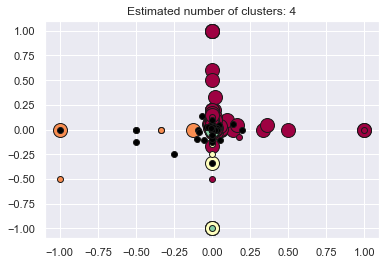

In [39]:
# Creating a dataset
X = (companies_df[['shopping_delivery_sent', 'phone_gadget_sent', 'customer_service_sent', 'flight_travel_sent', 
                      'account_details_sent', 'internet_sent', 'car_transport_sent', 'internet_sent', 
                      'payment_refunds_sent', 'entertainment_sent']])

db = DBSCAN(eps=0.2, min_samples=6, metric='cosine', n_jobs = -1).fit(X)
labels_db = db.labels_
n_clusters_ = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_ = list(labels_db).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels_db))

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Plotting the resulting clusters:
# Black removed and is used for noise instead.
unique_labels_db = set(labels_db)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels_db))]
for k, col in zip(unique_labels_db, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels_db == k)
    
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

companies_df['cluster'] = labels_db

# comp_grouped_df.to_csv('data/cs/cust_subsets/topic_clusters_by_comp.csv') # uncomment this line to save this df to a
                                                                            # .csv for further visualizations outside 
                                                                            #of Python